# Important information from the paper:

Q-network is the function approximator, which is used to approximate the Q-function that maps the station-action pairs to their values.

To successfully train the Q-function, we want to minimize the following loss:

$$
L_i(\theta_i) = E_{s, a \sim \rho(\cdot)}\left[(y_i - Q(s, a; \theta_i))^2\right]
$$

Where $y_i$

$$
y_i = E_{s, a \sim \rho(\cdot); s'\sim \text{Env}}\left[\left(r + \gamma \max_{a'} Q(s', a'; \theta_{i-1} - Q(s, a; \theta_i)\right) \nabla_{\theta_i} Q(s, a; \theta_i) \right]
$$


![Q-learning-algo.png](Q-learning-algo.png)

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def create_q_network(input_dim, n_layers, n_hidden, out_dim):
    dimensions = [input_dim] + n_layers * [n_hidden]

    layers = []
    for indim, outdim in zip(dimensions[:-1], dimensions[1:]):
        layers += [nn.Linear(indim, outdim), nn.ReLU()]
    layers += [nn.Linear(n_hidden, out_dim)]
    
    return nn.Sequential(*layers)

In [6]:
from collections import deque

class ReplayMemory:
    def __init__(self, max_len, batch_size=1):
        self.memory = deque([], maxlen=max_len)
        self.batch_size = batch_size
    def sample(self):
        batch_size = min(self.batch_size, len(self.memory))
        ids = np.random.randint(0, len(self.memory), size=batch_size)

        s0 = []
        a = []
        r = []
        s1 = []
        t = []
        
        for id in ids:
            s0.append(self.memory[id][0])
            a.append (self.memory[id][1])
            r.append (self.memory[id][2])
            s1.append(self.memory[id][3])
            t.append (self.memory[id][4])
        
        return torch.tensor(s0), torch.tensor(a), torch.tensor(r), torch.tensor(s1), torch.tensor(t)

    def add_memory(self, mem):
        self.memory.append(mem)

In [7]:
N = 2000      # Memory buffer capacity
GAMMA = 0.999 # Discount rate
EPS = 0.1     # Epsilion for eps greedy

replay_memory = ReplayMemory(N, 32)

in_dim = 4
n_layers = 3
n_hidden = 32
out_dim = 2

# Initialize the model
model = create_q_network(in_dim, n_layers, n_hidden, out_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
env = gym.make("CartPole-v1")

In [8]:
def train_one_epoch(episodes):
    ep_lens = []
    global EPS
    for _ in range(episodes):
        obs, _ = env.reset()
        obs = torch.tensor(obs)
        
        ep = 0
        done = False
        
        while not done:
            if np.random.random() < EPS:
                act = env.action_space.sample()
            else:
                q = model(obs)
                act = q.argmax().item()
            
            new_obs, rew, term, trun, _ = env.step(act)
            new_obs = torch.tensor(new_obs)
            done = term
            replay_memory.add_memory((obs.tolist(), act, rew, new_obs.tolist(), done))
            obs = new_obs
            
            s0, a, r, s1, t = replay_memory.sample()
        
            y_hat = model(s0)[range(len(s0)), a]
            y     = r + model(s1).max(dim=1).values * ~t
        
            optimizer.zero_grad()
            loss = ((y - y_hat)**2).mean()
            loss.backward()
            optimizer.step()
            
            ep += 1
        
        ep_lens.append(ep)
    
    return ep_lens

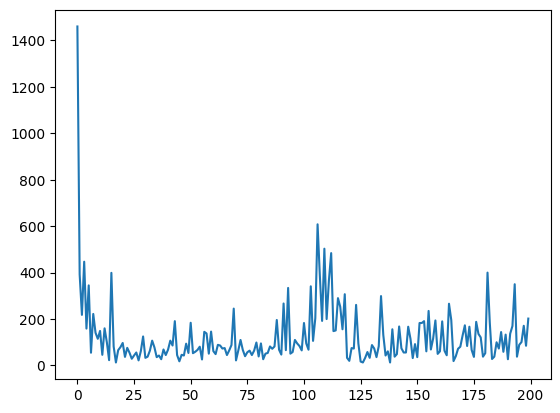

(array([109.,  42.,  26.,   8.,   6.,   5.,   2.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  13.  ,   85.35,  157.7 ,  230.05,  302.4 ,  374.75,  447.1 ,
         519.45,  591.8 ,  664.15,  736.5 ,  808.85,  881.2 ,  953.55,
        1025.9 , 1098.25, 1170.6 , 1242.95, 1315.3 , 1387.65, 1460.  ]),
 <BarContainer object of 20 artists>)

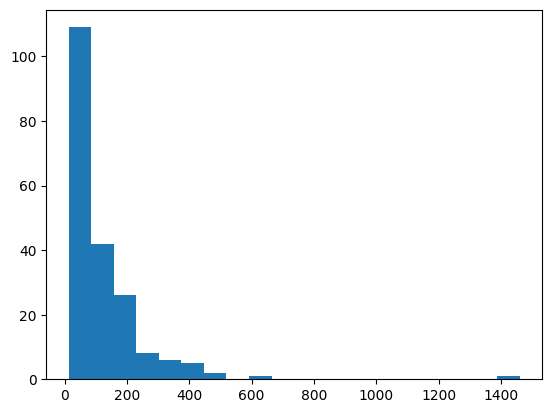

In [12]:
ep_lens = train_one_epoch(200)
plt.plot(ep_lens)
plt.show()
plt.hist(ep_lens, bins=20)

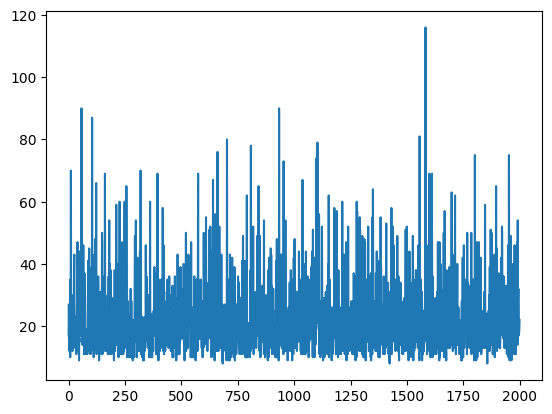

(array([952., 645., 226., 107.,  39.,  18.,   9.,   3.,   0.,   1.]),
 array([  8. ,  18.8,  29.6,  40.4,  51.2,  62. ,  72.8,  83.6,  94.4,
        105.2, 116. ]),
 <BarContainer object of 10 artists>)

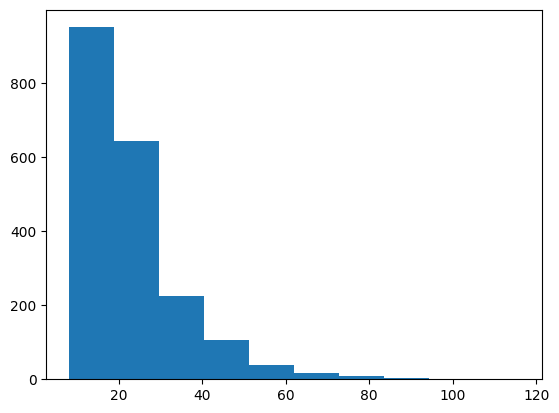

In [26]:
ep_lens = []

for _ in range(2000):
    done = False
    env.reset()
    ep = 0
    while not done:
        _, _, done, _, _ = env.step(env.action_space.sample())
        ep += 1
    ep_lens.append(ep)

plt.plot(ep_lens)
plt.show()
plt.hist(ep_lens)

In [ ]:
env = gym.make("CartPole-v1", render_mode='human')

for _ in range(50):
    done = False
    ep = 0
    obs, _ = env.reset()
    while not done:
        act = model(torch.tensor(obs)).argmax().item()
        obs, r, term, trun, _ = env.step(act)
        done = term or trun
        env.render()
        ep += 1
    print(ep)
env.close()

500
13
500
500
500
500
500
12
11
500
54
500
12
11
47
500
500
500
500
52
500
500
500
500
500
500
11
500
500
500
25
500
10
500
500
500
500
500


In [ ]:
env.close()